<a href="https://colab.research.google.com/github/kchl5/deep_learning_tutorial/blob/main/Marie/d2lai_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dive into deep learning : linear regression 


Exercises based on linear regression 
* [3.4](http://d2l.ai/chapter_linear-regression/linear-regression-scratch.html) implementation from scratch 
* [3.5](http://d2l.ai/chapter_linear-regression/linear-regression-concise.html) concise implementation 
* UvA tutorials 1 and 2

In [24]:
import torch 
import torch.nn as nn
import math 
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd 

## Progress bar
from tqdm.notebook import tqdm

*What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 1000 rather than 0.01?*

If we initialize the weights to 0, the output depends only on the bias b : can't backpropagate anything to w? 
Also issues if initialize all of the weights to excatly the same thing can never break symmetry?

if initial variance is very high : very unbalanced contribution of different features > issues for convergence? 

Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?



## Set up classifier and data 

based on 
* UvA [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html) 
* 3.3 synthetic regression [data](http://d2l.ai/chapter_linear-regression/synthetic-regression-data.html)
* pytorch tutorial on datasets and [dataloaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [Stanford](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel) data generator

In example here, linear regression task where have 10 features and output is a continuous value 

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn.datasets import make_regression 

In [4]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(0)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

`scikitlearn.datasets.make_regression` 

syntax is 
X, y = make_regression(n_samples, noise, random_state) 

returns:
* X: ndarray of shape (n_samples, n_features)
* y: yndarray of shape (n_samples,) or (n_samples, n_targets) the output value


In [5]:
class SyntheticData(Dataset):
  def __init__(self, n_samples, n_features):
    """
    Inputs: 
      - n_samples 
      - n_features
    """
    # Initialization 
    super().__init__()
    self.n_samples = n_samples
    self.n_features = n_features
    self.generate_reg_data()

  def generate_reg_data(self, SEED = 0):
    X, y = make_regression(self.n_samples, self.n_features, random_state = SEED)
    self.data = torch.tensor(np.float32(X)) # convert to float32 because pytorch weights are float32
    self.label = torch.tensor(np.float32(y))

  def __len__(self):
    # total number of samples
    return self.n_samples

  def __getitem__(self, index):
    # Return the idx-th data point of the dataset
    # If we have multiple things to return (data point and label), we can return them as tuple
    data_point = self.data[index]
    data_label = self.label[index]

    return data_point, data_label




In [6]:
# Create a dataset and inspect it: 
dataset = SyntheticData(n_samples = 1000, n_features = 10)
print("Size of dataset:", len(dataset))
print("Datapoint 0", dataset[0])

Size of dataset: 1000
Datapoint 0 (tensor([ 1.6090,  0.5277,  1.6492, -0.4915, -1.0984,  1.0651,  0.6897, -0.2226,
        -0.0026,  0.1430]), tensor(224.7676))


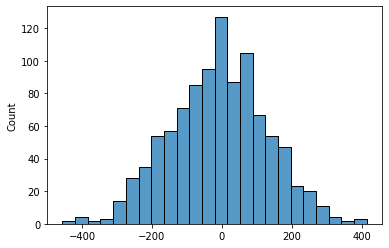

In [7]:
sns.histplot(dataset.label)

In [8]:
# Now create simple linear regression model

class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super().__init__()

    # Initialize modules for simple linear regression
    ## when call nn.Linear(), pytorch does default weight and bias initialization 
    self.linear1 = nn.Linear(in_features = num_inputs, 
                             out_features = num_outputs)
    
  def forward(self, x):
    # Perform calculation of the model 
    return self.linear1(x)

  

  

In [9]:
model = Net(num_inputs = 10,
            num_outputs = 1)

In [10]:
print(model)

Net(
  (linear1): Linear(in_features=10, out_features=1, bias=True)
)


In [11]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, dtype {param.dtype}")


Parameter linear1.weight, shape torch.Size([1, 10]), dtype torch.float32
Parameter linear1.bias, shape torch.Size([1]), dtype torch.float32


In [12]:
# Loss module
loss_module = nn.MSELoss()
# Stochastic gradient descent 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
# Split data for training and testing : 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [61]:
print(len(dataset))

1000


In [14]:
# Create dataloader objects
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10, shuffle = True)

In [62]:
print(len(train_loader)) # 80 batches of 10 samples?

80


In [15]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
train_inputs, train_labels = next(iter(train_loader))

In [16]:
train_labels

tensor([-209.7723,  -15.1545, -118.1693,  -31.1929,   82.0161, -111.6834,
         -99.4355, -117.7682, -124.7946, -308.0148])

In [57]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # set up loss list 
    loss_values = []
    epochs_list = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):      
      epoch_loss = 0.0

      for data_inputs, data_labels in data_loader:
        ## Step 1: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
        
        ## Step 2: Calculate the loss
        loss = loss_module(preds, data_labels)
        
        ## Step 3: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()

        # Perform backpropagation
        loss.backward()
        
        ## Step 4: Update the parameters
        optimizer.step()
        
        ## Step 5: take the running average of the loss 
        epoch_loss += loss.item()

      # Compute average loss 
      epoch_loss /= len(data_inputs)
      loss_values.append(epoch_loss)
      epochs_list.append(epoch)

    # Output plot
    loss_df = pd.DataFrame({"epoch" : epochs_list, 
                            "loss" : loss_values})
    
    sns.lineplot(x = loss_df.epoch, 
             y = loss_df.loss).set(title = "Training loss");

    plt.show()




  0%|          | 0/100 [00:00<?, ?it/s]

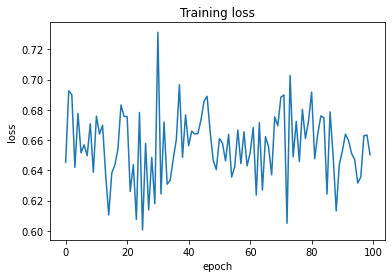

In [58]:
train_model(model, optimizer, train_loader, loss_module, num_epochs = 100)

In [69]:
# Evaluate accuracy on test set:

def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)

            # Keep records of predictions 
            loss_value = loss_module(preds, data_labels)

    loss_value /= len(data_loader)

    print("MSE:", loss_value.item())




In [70]:
eval_model(model, test_loader, loss_module)

MSE: 0.005211567971855402


In [52]:
## Introduce non-linearity 

class Net2(nn.Module):
  def __init__(self, num_input, num_hidden, num_outputs):
    super().__init__()
    
    self.linear1 = nn.Linear(num_input, num_hidden)
    self.actv = nn.LeakyReLU()
    self.linear2 = nn.Linear(num_hidden, num_outputs)

  def forward(self, x):
    x = self.linear1(x)
    x = self.actv(x)
    x = self.linear2(x)
    return x 

In [53]:
model2 = Net2(num_input = 10, 
              num_hidden = 4, 
              num_outputs = 1)

  0%|          | 0/100 [00:00<?, ?it/s]

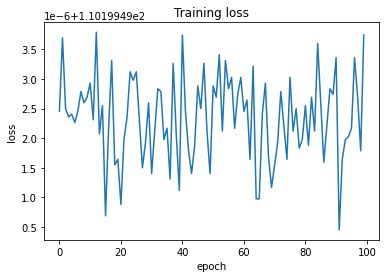

In [54]:
train_model(model2, optimizer, train_loader, loss_module, num_epochs = 100)

In [71]:
eval_model(model2, test_loader, loss_module)

MSE: 5.6700263023376465
